In [42]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import subprocess
import os.path
from os import listdir
from os.path import isfile, join

In [34]:
rundataPath = '../rundata/'
generatorDir = '../bin/'
generator = 'StraussUnits'

In [6]:
# Solar cycle polarity
Ac = -1
# Magnetic field
rRefB = 1.0
rSun = 0.005 # AU
B0 = 5e-9 / np.sqrt(1 + (rRefB - rSun)**2) * 4.485e10 # GV / AU
Omega = 2.0 * np.pi / (25.4 * 24.0 * 3600.0) # rad / s
Vsw = 400 * 6.685e-9 # AU / s
# Electron mass
me = 0.000511
qe = -1
# Diffusion parameters
lambda0 = 0.15 # AU
kperp_kpar = 0.01

In [7]:
def momentum(ek):
    return np.sqrt(ek * (ek + 2.0 * me)) # GeV

In [8]:
def velocity(ek):
    return 0.002 * np.sqrt(ek * (ek + 2.0 * me)) / (ek + me) # AU / s

In [9]:
def rigidity(ek):
    return np.sqrt(ek * (ek + 2.0 * me)) # GV

In [10]:
def getB(r, th, ph):    
    bFact = Ac * B0 * (rRefB / r)**2
    
    return {bFact, 0.0, -bFact * (r - rSun) * Omega / Vsw * np.sin(th)}

In [11]:
def getK(r, th, ph, ek):
    # Diffusion tensor
    k = {'rr': 0.0, 'thth': 0.0, 'phph': 0.0, 'rth': 0.0, 'rph': 0.0, 'thr': 0.0, 'thph': 0.0, 'phr': 0.0, 'phth': 0.0}
    
    # Set up convenience variables
    p = momentum(ek)
    v = velocity(ek)
    B = getB(r, th, ph, -1)
    
    # Asymmetric part of k in spherical coordinates
    kAFact = p * v / (3 * qe * (B['r']**2 + B['ph']**2))
    k['rth'] = kAFact * B['ph']
    k['thr'] = -kAFact * B['ph']
    k['thph'] = kAFact * B['r']
    k['phth'] = -kAFact * B['r']

    # Symmetric part of k
    kpar = v / 3 * lambda0 * (1 + r / rRefLambda)
    if p > p0:
        kpar = kpar * p / p0
    kperp = kperp_kpar * kpar
    
    # Convert symmetric part to spherical coordinates
    tanPsi = Omega * (r - rSun) * np.sin(th) / Vsw
    cosPsi = 1 / np.sqrt(1 + tanPsi**2)
    sinPsi = np.sqrt(1 - cosPsi**2)
    
    k['rr'] = kpar * cosPsi**2 + kperp * sinPsi**2
    k['phph'] = kpar * sinPsi**2 + kperp * cosPsi**2
    k['thth'] = kperp
    k['rph'] = k['rph'] + (kperp - kpar) * cosPsi * sinPsi
    k['phr'] = k['phr'] + (kperp - kpar) * cosPsi * sinPsi
    
    return k

###j_LIS from arXiv:1302.2424 [astro-ph.HE].  Valid for 1 MeV <= E <= 50 GeV.

In [12]:
def jLISPotgieter(ek):
    """
    Computes differential intensity for cosmic ray electrons at the heliopause.
    ek: electron energy in GeV.  Must be between 1 MeV and 50 GeV.
    Returns: differential intensity in m^-2 s^-1 sr^-1 MeV^-1
    """
    if ek < 0.001:
        return -1
    elif ek > 50:
        return -2
    elif ek >= 0.001 and ek <= 1.0:
        return np.exp(-2.0 - 1.511 * np.log(ek))
    elif ek > 1.0 and ek <= 10.0:
        return (0.1349 - 6.6e-3 * ek + 15.49e-5 * ek**2) / (1 - 1.3187 * ek + 1.0810 * ek**2 + 0.2327 * ek**3)
    elif ek > 10.0:
        return np.exp(-0.89 - 3.262 * np.log(ek))

###j_LIS from Langner et al 2001 (doi:10.1016/S0273-1177(01)00100-4)

In [13]:
def jLISLangner(ek):
    """
    LIS parametrization from Langner 2004, with correction from Strauss' code.  ek is in GeV.
    Returns: j_LIS in units of particles m^-2 s^-1 sr^-1 MeV^-1.
    """
    P = rigidity(ek) / 1.0 # P0 = 1.0 GV
    
    if P < 0.0026:
        a = 126.067948848145
        b = 0.2567973348983205
        c = 1.95129069032843
        d = 0.0171199701826333
        
        return 1.7 * (a + c * np.log(P)) / (1.0 + b * np.log(P) + d * np.log(P)**2)
    elif P >= 0.0026 and P < 0.1:
        return 1.7 * ((52.55 + 23.01 * P) / (1.0 + 148.62 * P))**2
    elif P >= 0.1 and P <= 10.0:
        return (1555.89 + 17.36 * P - 3.4e-3 * P**2 + 5.13e-7 * P**3)/(1.0 - 11.22 * P + 7532.93 * P**2 + 2405.01 * P**3 + 103.87 * P**4)
    elif P > 10.0:
        return 1.7 * np.exp(-0.89 - 3.22 * np.log(P))

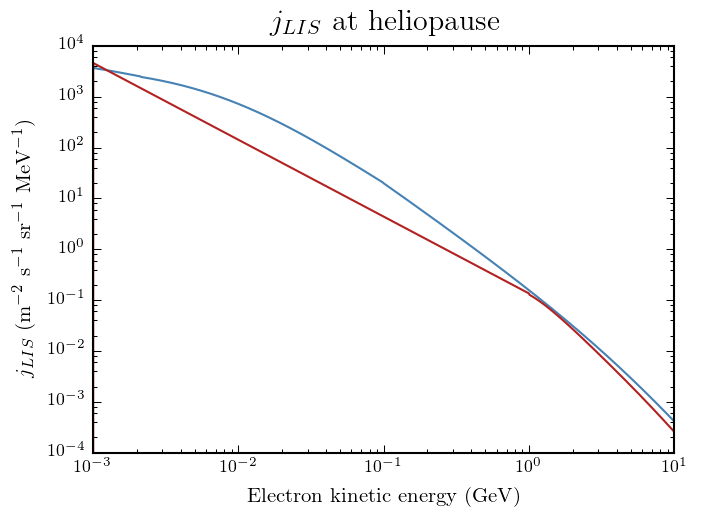

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#eksPotgieter = 10 ** np.linspace(np.log10(0.001), np.log10(50.0), 100) # Energies in GeV
#ax.plot(eks, [jLISPotgieter(ek) * (ek / 1000)**2 * 1.0e-4 for ek in eksPotgieter])

eksLangner = 10.0 ** np.linspace(-4.0, 1.0, 1000) # Energies in GeV
ax.plot(eksLangner, [jLISLangner(ek) for ek in eksLangner])
ax.plot(eksLangner, [jLISPotgieter(ek) for ek in eksLangner])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1e1)
ax.set_ylim(1e-4, 1e4)
ax.set_ylabel(r'$j_{LIS}$ (m$^{-2}$ s$^{-1}$ sr$^{-1}$ MeV$^{-1}$)')
ax.set_xlabel(r'Electron kinetic energy (GeV)')
ax.set_title(r'$j_{LIS}$ at heliopause')

plt.show()

###Compute intensity at a point

In [15]:
def getJ(runName):
    """
    Performs MC integration to find the differential intensity at earth for a given run.
    runName: csv containing trajectory exit points.
    Returns:
        intitialPoint: the point at which the cosmic rays were observed and their energy.
        j: the differential intensity at that point and energy.
        sigma: the error on j.
    """
    # Load exit points
    rawData = np.loadtxt(rundataPath + runName + '.csv', delimiter = ',')
    # Parse out the coordinates and energies into a list of tuples of exit points
    exitData = [{'ee': ee, 'the': the, 'phe': phe} for ee, the, phe in zip(rawData[:,3], rawData[:,1], rawData[:,2])]
    
    # Get initial point.  --->>> TODO: store initial point in first line of csv!!!
    r0 = 1.0
    th0 = np.pi / 2.0
    ph0 = 0.0
    e0 = 0.1
    initialPoint = {'r0': r0, 'th0': th0, 'ph0': ph0, 'e0': e0}
    
    # Average LIS at exit points
    #print([jLIS(ep['ee']) for ep in exitData][:10])
    jN = sum([jLISLangner(ep['ee']) / rigidity(ep['ee'])**2 for ep in exitData]) / float(len(exitData)) * rigidity(e0)**2
    
    # Compute error
    varjN = sum([(jLISLangner(ep['ee']) * (rigidity(e0) / rigidity(ep['ee']))**2 - jN)**2 for ep in exitData])
    varjN = varjN * 1.0 / (len(exitData) - 1.0)
    
    return (initialPoint, jN, np.sqrt(varjN / len(exitData)))

In [16]:
x0, j, sigma = getJ('straussunits_alt0_run5')
print('e0 = ' + str(x0['e0']) + ' GeV, j(x0) = ' + str(j) + ' +/- ' + str(sigma) + ' MeV^-1 s^-1 sr^-2 m^-2')

x0, j, sigma = getJ('straussunits_agt0_run0')
print('e0 = ' + str(x0['e0']) + ' GeV, j(x0) = ' + str(j) + ' +/- ' + str(sigma) + ' MeV^-1 s^-1 sr^-2 m^-2')

e0 = 0.1 GeV, j(x0) = 0.121144599246 +/- 0.00178845104754 MeV^-1 s^-1 sr^-2 m^-2
e0 = 0.1 GeV, j(x0) = 0.0305332190789 +/- 0.00190744092167 MeV^-1 s^-1 sr^-2 m^-2


In [17]:
x0, j, sigma = getJ('strauss_run5')
print('e0 = ' + str(x0['e0']) + ' GeV, j(x0) = ' + str(j) + ' +/- ' + str(sigma) + ' MeV^-1 s^-1 sr^-2 m^-2')

e0 = 0.1 GeV, j(x0) = 0.117378917067 +/- 0.00172594595069 MeV^-1 s^-1 sr^-2 m^-2


In [51]:
# Build the spectrum at earth
energies = [os.path.splitext(f)[0] for f in listdir(rundataPath + 'alt0_spectrum/') if isfile(join(rundataPath + 'alt0_spectrum/', f))]

e0s = [float(e) for e in energies]
js = [getJ('alt0_spectrum/' + e)[1] for e in energies]
sigmas = [getJ('alt0_spectrum/' + e)[2] for e in energies]

(0.0001, 10000.0)

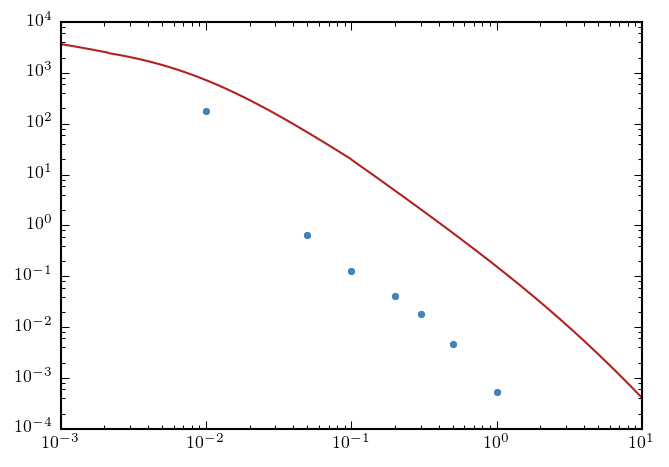

In [52]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(e0s, js, '.')

eksLangner = 10.0 ** np.linspace(-3.0, 2.0, 1000) # Energies in GeV
ax.plot(eksLangner, [jLISLangner(ek) for ek in eksLangner])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1e1)
ax.set_ylim(1e-4, 1e4)

###Functions to compute anisotropy Earth's position

In [28]:
def generateRuns(fName, dirName, e0, n, dr, dth, dph, de):
    """
    Generates files needed to take derivatives of j.
    e0: energy the electron was observed to have at Earth.
    n: number of runs to generate for each file.
    dr, dth, dph, de: step sizes to use for taking the derivatives.
    fName: base file name.
    dirName: base directory in which to store runs.  Must be an existing subdirectory of rundataPath.
    TODO: THREAD THIS.
    """
    baseName = dirName + '/' + fName
    
    # Check whether files exists before generating them
    if not os.path.isfile(rundataPath + baseName + '.csv'):
        subprocess.call([generatorDir + generator, str(e0), str(n), baseName])

In [19]:
def getjDerivs(fName, dirName):
    """
    fName: file name with trajectories measured to have desired energy at Earth.  The start point in this file defines
           Earth's position.  The 
    Returns: numerical approximations of dj/dr, dj/dth, dj/dph, dj/dT at Earth.  Also gives x, the Earth point.
    """
    # Get j at Earth
    xEarth, jEarth = getJ(dirName + '/' + fName)
    # Get j at each of the points shifted spatially/spectrally from the one we care about
    x_dr, j_dr = getJ(dirName + '/' + fName + '_dr')
    x_dth, j_dth = getJ(dirName + '/' + fName + '_dth')
    x_dph, j_dph = getJ(dirName + '/' + fName + '_dph')
    x_de, j_de = getJ(dirName + '/' + fName + '_de')
    
    # Compute derivatives
    dj_dr = (j_dr - jEarth) / (x_dr['r0'] - xEarth['r0'])
    dj_dth = (j_dth - jEarth) / (x_dth['th0'] - xEarth['th0'])
    dj_dph = (j_dph - jEarth) / (x_dph['ph0'] - xEarth['ph0'])
    dj_de = (j_de - jEarth) / (x_de['e0'] - xEarth['e0'])
    
    return (xEarth, jEarth, {"dj_dr": dj_dr, "dj_dth": dj_dth, "dj_dph": dj_dph, "dj_de": dj_de})

In [22]:
def getAnisotropy(fName):
    """
    Computes anisotropy at position specified in the provided file.  Files required for computing derivatives must
    exist.  (See eq 1-2b in Jokipii and Kopriva 1979.)
    """
    # Set up convenience variables
    xEarth, jEarth, dj = getjDerivs(fName)
    e0 = xEarth['ek']
    k = getK(xEarth['r0'], xEarth['th'], xEarth['ph'], e0)
    
    # Streaming flux
    sfFact = 4.0 * np.pi / velocity(e0)
    sf = {'r': sfFact, 'th': sfFact, 'ph': sfFact}
    
    # Angular components
    sf['th'] = -sf['th'] * (k['thr'] * dj['dj_dr'] + k['thth'] * dj['dj_dth'] + k['thph'] * dj['dj_dph'])    
    sf['ph'] = -sf['ph'] * (k['phr'] * dj['dj_dr'] + k['phth'] * dj['dj_dth'] + k['phph'] * dj['dj_dph'])
    
    # r component has solar wind contribution
    sf['r'] = sf['r'] * (-k['rr'] * dj['dj_dr'] - k['rth'] * dj['dj_dth'] - k['rph'] * dj['dj_dph']
                        + Vsw * (jEarth - 1.0 / (3.0 * velocity(e0))
                                 * (jEarth * (1 + me**2 / (me + e0)**2)
                                    + e0 * (e0 + 2 * me) / (e0 + me)
                                        * (dj['dj_de'] - jEarth / velocity(e0) * me**2 / (velocity(e0) * (me + e0)**3)))))
    delta = {'r': 3.0 / (4.0 * np.pi * jEarth) * sf['r'],
             'th': 3.0 / (4.0 * np.pi * jEarth) * sf['th'],
             'ph': 3.0 / (4.0 * np.pi * jEarth) * sf['ph']}

In [29]:
generateRuns('alt0_100MeV_run0', 'anisotropyTest0', 0.1, 50000, 0, 0, 0, 0)

In [30]:
generateRuns('alt0_100MeV_run1', 'anisotropyTest0', 0.1, 50000, 0, 0, 0, 0)

In [31]:
generateRuns('alt0_100MeV_run2', 'anisotropyTest0', 0.1, 50000, 0, 0, 0, 0)